<h1>Hands on Session </h1>
This notebook gives the step by step instructions on how to create ARIMA Model  on Store Sales Dataset from Kaggle
from Kaggle.

## Import the packages required for the excersice

In [49]:
import math
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
import seaborn as sb
from sklearn.metrics import mean_squared_error
from bokeh.io import output_notebook, show 
from bokeh.plotting import figure
import matplotlib.pyplot as plt
output_notebook()
%load_ext autoreload
%autoreload 1
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=(6,4)

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import and Collate Dataset

In [50]:
print("Load the training, test and store data using pandas")
train = pd.read_csv("train.csv")
store = pd.read_csv("store.csv")

Load the training, test and store data using pandas


In [51]:
train["Date"] = pd.to_datetime(train["Date"]).dt.date
train = train.sort_values(by='Date')
###### 
y=train[train.Store==6].set_index('Date')[['Sales']].asfreq('D')
X=train[train.Store==6].set_index('Date').asfreq('D')
y.shape[0]==942 

True

### Visualize the Data

In [55]:
store.tail()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN
1114,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


In [54]:
train[train['Store']==1].head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1016095,1,2,2013-01-01,0,0,0,0,a,1
1014980,1,3,2013-01-02,5530,668,1,0,0,1
1013865,1,4,2013-01-03,4327,578,1,0,0,1
1012750,1,5,2013-01-04,4486,619,1,0,0,1
1011635,1,6,2013-01-05,4997,635,1,0,0,1


In [29]:
ts=pd.DataFrame(y)

##  Exploratory Data Analysis

### Visualize the time Series Data

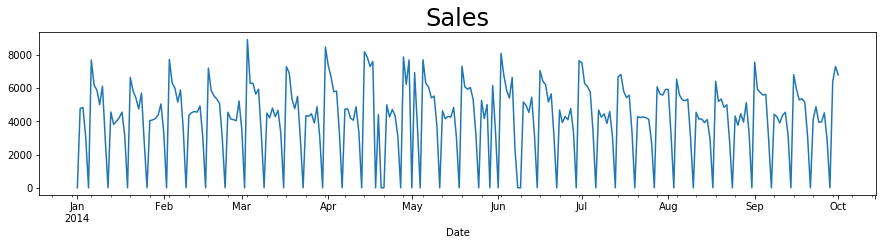

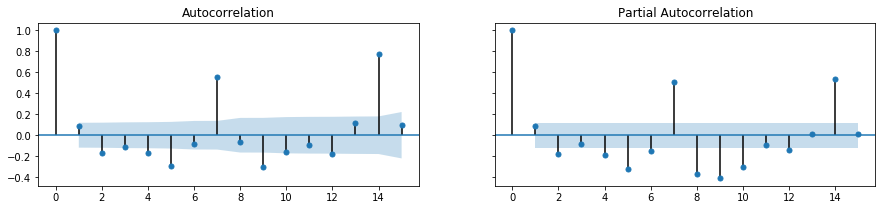

In [35]:
# ts['ln_Sales'] = np.log(ts.Sales+100)
X_train['Sales_d7'] = ts.Sales.diff(7)
X_train['Sales_d14'] = ts.Sales.diff(14)
X_train['Sales_d14d1'] = ts.Sales.diff(14).diff(1)
# Graph data
for x in [X_train.Sales]:
    fig, axes = plt.subplots(1, 1, figsize=(15,3))
    x=x['2014-01-01':'2014-10-01']
    ax=x.plot(ax=axes)
    ax.set_title(x.name)
    ax.title.set_fontsize(24)
    
    fig, axes = plt.subplots(1, 2, figsize=(15,3),sharex=True,sharey=True)
    sm.graphics.tsa.plot_acf(x, lags=15,ax=axes[0]);
    sm.graphics.tsa.plot_pacf(x, lags=15, ax=axes[1]);

## Feature Cleaning

## Feature Engineering

In [37]:
_X=X_exog[['Open','Promo','SchoolHoliday']]
_X['StateHoliday']=X_exog.StateHoliday.astype(str).replace(['a', 'b', 'c'],'0').astype(np.float)
_X['Month']=X_exog.index.month
_X['WeekDay']=X_exog.index.weekday
_X['time']=(X_exog.index-X_exog.index.min()).days
_X['const']=1
_X
_Y=Y_exog[['Open','Promo','SchoolHoliday']]
_Y['StateHoliday']=Y_exog.StateHoliday.astype(str).replace(['a', 'b', 'c'],'0').astype(np.float)
_Y['Month']=Y_exog.index.month
_Y['WeekDay']=Y_exog.index.weekday
_Y['time']=(Y_exog.index-Y_exog.index.min()).days
_Y['const']=1

## Model Development

### Divide data into Train Test Split

In [38]:
X_train = ts[ts.index < '2015-04-01']
X_exog = X[X.index < '2015-04-01']
X_test = ts[ts.index >=  '2015-04-01']
Y_exog = X[X.index >= '2015-04-01']
len(X_test)

122

### Model Development

### Call Seasonal ARIMA 

In [39]:
SARIMAX = sm.tsa.statespace.SARIMAX

In [45]:
arma = SARIMAX(X_train.Sales, exog=_X, trend=None, order=(1,0,0),seasonal_order=(2,1,1,14))
%time arma = arma.fit()
print(arma.summary())

CPU times: user 2min 19s, sys: 301 ms, total: 2min 19s
Wall time: 23.3 s
                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  820
Model:             SARIMAX(1, 0, 0)x(2, 1, 1, 14)   Log Likelihood               -6437.493
Date:                            Thu, 17 Jan 2019   AIC                          12900.986
Time:                                    08:56:13   BIC                          12961.983
Sample:                                01-01-2013   HQIC                         12924.410
                                     - 03-31-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Open           5473.3907     93.768